In [1]:
%%script off
from astropy.io import votable
path = '/Users/mlombard/Downloads/starjava-master/votable/src/testcases/uk/ac/starlink/votable/gaiats.vot'
vo = votable.parse(path)
table = vo.get_first_table()
#xc = PhotometricCatalogue(table)
field = table.fields[4]
votable.ucd.parse_ucd(field.ucd)

Couldn't find program: 'off'


In [1]:
cd "/Users/mlombard/src/python/xnicer"

/Users/mlombard/src/python/xnicer


In [2]:
import numpy as np
import logging
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy import table
from astropy.coordinates import SkyCoord
from xnicer import XNicer, XDGaussianMixture, guess_wcs, make_maps
from xnicer.catalogs import AstrometricCatalogue, PhotometricCatalogue, ColorCatalogue

path = '/Users/mlombard/TeX/art64/Vision/'
cat_c = ascii.read(path + 'control.dat', readme=path + 'ReadMe')

In [3]:
# Create a photometric catalog for the control field data. For this catalogue,
reddening_law = [2.50, 1.55, 1.00]
mags = ["Jmag", "Hmag", "Ksmag"]
mag_errs = ["e_Jmag", "e_Hmag", "e_Ksmag"]
phot_c = PhotometricCatalogue.from_table(cat_c, mags, mag_errs, 
                              reddening_law=reddening_law,
                              class_names=["star", "galaxy"], class_prob_names=["ClassCog"],
                              log_class_probs=False)
phot_c.add_log_probs()

In [3]:
# Create a photometric and an astrometric catalogue for the science field.
cat_s = ascii.read(path + 'science.dat', readme=path + 'ReadMe')
phot_s = PhotometricCatalogue.from_table(cat_s, mags, mag_errs, 
                              reddening_law=reddening_law, 
                              class_names=["star", "galaxy"], class_prob_names=["ClassSex"],
                              log_class_probs=False)
coord_s = AstrometricCatalogue.from_table(cat_s, ['RAdeg', 'DEdeg'], unit='deg', frame='icrs')

In [4]:
%%time
# Cython CLang
# logging.basicConfig(level=logging.DEBUG)
xd = XDGaussianMixture(n_components=5, n_classes=1, splitnmerge=0, tol=0.0, max_iter=100)
# xnicer = XNicer(xd, np.linspace(0.0, 4.0, 5))
xnicer = XNicer(xd, [0.0])
xnicer.fit(phot_c)
xd.weights_, xd.means_

xdeconv did not converge after 100 iterations
CPU times: user 3min 16s, sys: 1.57 s, total: 3min 17s
Wall time: 19.2 s
/Users/mlombard/src/python/xnicer/xnicer/xdeconv/xdeconv.py:303: UserWarning: xdeconv did not converge after 100 iterations
  warnings.warn(f'xdeconv did not converge after {maxiter} iterations')


(array([0.27860643, 0.38310934, 0.09196954, 0.24522639, 0.00108831]),
 array([[0.82213419, 0.75466603],
        [0.59026869, 0.2147515 ],
        [0.7707643 , 0.67915257],
        [0.41216995, 0.08385747],
        [0.55464909, 0.40183641]]))

In [6]:
%%time
# Bovy GCC
# logging.basicConfig(level=logging.DEBUG)
xd = XDGaussianMixture(n_components=5, n_classes=1, splitnmerge=0, tol=1e-15, max_iter=100)
# xnicer = XNicer(xd, np.linspace(0.0, 4.0, 5))
xnicer = XNicer(xd, [0.0])
xnicer.fit(phot_c)
xd.weights_, xd.means_

LOWER BOUND =  2.572053861663901
CPU times: user 2min 6s, sys: 17.2 s, total: 2min 23s
Wall time: 15 s


(array([0.24476471, 0.17714687, 0.38532992, 0.00135742, 0.19140108]),
 array([[0.411753  , 0.08375239],
        [0.7954754 , 0.7154845 ],
        [0.59017578, 0.21470893],
        [0.57286084, 0.41492384],
        [0.82434048, 0.76015993]]))

In [7]:
%%time
# Bovy CLang
# logging.basicConfig(level=logging.DEBUG)
xd = XDGaussianMixture(n_components=5, n_classes=1, splitnmerge=0, tol=1e-15, max_iter=100)
# xnicer = XNicer(xd, np.linspace(0.0, 4.0, 5))
xnicer = XNicer(xd, [0.0])
xnicer.fit(phot_c)
xd.weights_, xd.means_

LOWER BOUND =  1.1200824071358113
CPU times: user 8.36 s, sys: 147 ms, total: 8.51 s
Wall time: 1.64 s


(array([0.07242312, 0.15115003, 0.15623034, 0.36330991, 0.2568866 ]),
 array([[0.22488738, 0.16192974],
        [0.23560699, 0.06981435],
        [0.21457912, 0.15161004],
        [0.26764329, 0.14208269],
        [0.25296809, 0.18527378]]))

In [9]:
%%time
phot_c.fit_number_counts()

CPU times: user 448 ms, sys: 1.52 ms, total: 449 ms
Wall time: 449 ms


array([[ 0.5150972 , 20.66621134,  0.26327824],
       [ 0.54589686, 19.96456563,  0.23473764],
       [ 0.61590493, 19.11192556,  0.21518759]])

In [10]:
%%time
phot_c.fit_phot_uncertainties()

CPU times: user 12.9 s, sys: 1.47 s, total: 14.4 s
Wall time: 2.42 s


array([[24.62052699,  0.67003248, 25.39742041,  4.57721237],
       [24.42010013,  0.59271107, 19.4299333 , 54.44259829],
       [23.54089604,  0.51432745, 28.0523679 , 50.45724783]])

In [12]:
%%time
xnicer.calibrate(phot_c, np.linspace(0.0, 5.0, 11))

CPU times: user 38.3 s, sys: 4.73 s, total: 43 s
Wall time: 8.9 s


In [9]:
w = np.where(np.all(phot_c['mag_errs'] < phot_c.meta['null_err'], axis=1))[0]
# w = np.arange(len(phot_c))
ext_c = xnicer.predict(phot_c[w])
weight_c = 1.0 / ext_c['variance_A']
bias_c = np.sum(ext_c['mean_A'] * weight_c) / np.sum(weight_c)
stdv_c = np.sqrt(np.sum(ext_c['mean_A'] ** 2 * weight_c ** 2) / \
    np.sum(weight_c)**2) * np.sqrt(len(weight_c))
print(f"Bias = {bias_c:.3f}")
print(f"Stdv = {stdv_c:.3f}")

Bias = -0.001
Stdv = 0.143


Bias = 0.031
Stdv = 0.277


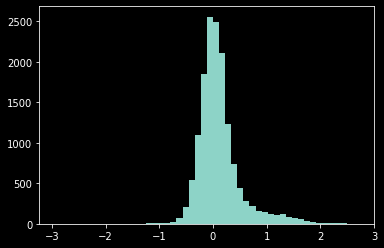

In [11]:
w = np.where(np.any(phot_c['mag_errs'] >= phot_c.meta['null_err'], axis=1))[0]
ext_c = xnicer.predict(phot_c[w])
weight_c = 1.0 / ext_c['variance_A']
bias_c = np.sum(ext_c['mean_A'] * weight_c) / np.sum(weight_c)
stdv_c = np.sqrt(np.sum(ext_c['mean_A'] ** 2 * weight_c ** 2) / \
    np.sum(weight_c)**2) * np.sqrt(len(weight_c))
print(f"Bias = {bias_c:.3f}")
print(f"Stdv = {stdv_c:.3f}")
plt.hist(ext_c['mean_A'], bins=50);

Bias = 0.124
Stdv = 0.311


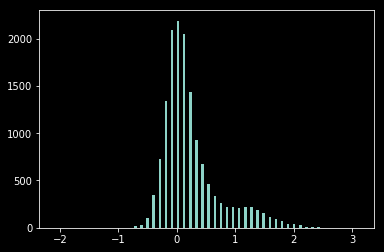

In [28]:
w = np.where(np.any(phot_c['mag_errs'] >= phot_c.meta['null_err'], axis=1))[0]
w1 = np.where(phot_c['log_class_probs'][w,0] > np.log(0.5))[0]
w2 = np.where(phot_c['log_class_probs'][w,0] < np.log(0.5))[0]
ext_c = xnicer.predict(phot_c[w])
weight_c = 1.0 / ext_c['variance_A']
bias_c = np.sum(ext_c['mean_A'] * weight_c) / np.sum(weight_c)
stdv_c = np.sqrt(np.sum(ext_c['mean_A'] ** 2 * weight_c ** 2) / \
    np.sum(weight_c)**2) * np.sqrt(len(weight_c))
print(f"Bias = {bias_c:.3f}")
print(f"Stdv = {stdv_c:.3f}")
plt.hist((ext_c['mean_A'][w1], ext_c['mean_A'][w2]), bins=50);


In [43]:
cat_c['ClassSex'][phot_c['idx'][w]]

1.0
1.0
1.0
1.0
...
1.0
1.0
1.0


In [36]:
cat_c

VISION,RAdeg,DEdeg,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,ClassCog,ClassSex,JMJD,HMJD,KsMJD,JExpTime,HExpTime,KsExpTime,JFWHM,HFWHM,KsFWHM,JSeeing,HSeeing,KsSeeing,JCov,HCov,KsCov,Japer,Haper,Ksaper,J2massId,H2massId,Ks2massId,Jorigin,Horigin,Ksorigin
,deg,deg,mag,mag,mag,mag,mag,mag,,,d,d,d,s,s,s,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,,,,arcsec,arcsec,arcsec,,,,,,
str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,str16,str16,str16,str6,str6,str6
06144543-2700324,93.689293,-27.009006,13.082,0.005,12.578,0.004,12.474,0.006,1,1.0,56294.328,56338.18,56341.188,20,12,10,0.72,0.76,0.84,0.68,0.73,0.77,4,6,5,3.0,3.0,3.0,06144543-2700325,06144543-2700325,06144543-2700325,VISION,VISION,VISION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06110049-2546435,92.752072,-25.778757,--,--,--,--,19.224,0.196,0,1.0,--,--,56341.191,--,--,24,--,--,0.88,--,--,0.84,--,--,12,--,--,3.0,--,--,--,--,--,VISION


In [7]:
from xnicer import guess_wcs, make_maps
from xnicer.kde import KDE

In [8]:
ext_s = xnicer.predict(phot_s, n_iters=1, full=True)

In [9]:
wcs = guess_wcs(coord_s.galactic, target_density=5.0)
smoother = KDE(tuple(reversed(wcs.pixel_shape)), max_power=2)
hdu = make_maps(coord_s.galactic, ext_s, wcs, smoother)
maps = hdu.data

In [10]:
maps.shape

(4, 210, 726)

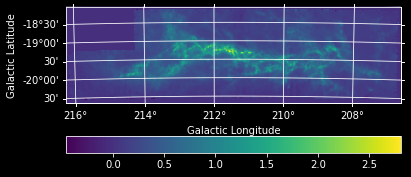

In [11]:
plt.subplot(projection=wcs)
plt.imshow(maps[0], origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.colorbar(orientation='horizontal')


In [12]:
# Code from astroML.plotting.tools import draw_ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    from matplotlib.patches import Ellipse
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

In [21]:
path = '/Users/mlombard/TeX/art64/Vision/'
cat_all = ascii.read(path + 'control.dat', readme=path + 'ReadMe')

np.random.seed(1);
a = np.random.random(size=(len(cat_all),)) - 0.5
mags = ["Jmag", "Hmag", "Ksmag"]
mag_errs = ["e_Jmag", "e_Hmag", "e_Ksmag"]
reddening_law = [2.50, 1.55, 1.00]
cat_c = PhotometricCatalogue.from_table(cat_all[a < 0], mags, mag_errs, reddening_law=reddening_law)
cat_s = PhotometricCatalogue.from_table(cat_all[a > 0], mags, mag_errs, reddening_law=reddening_law)

#cat_c = PhotometricCatalogue.from_table(cat_all[a < 0], mags, mag_errs, reddening_law=reddening_law,
#                              class_names=["star", "galaxy"], class_prob_names=["ClassSex"], log_class_probs=False)
#cat_s = PhotometricCatalogue.from_table(cat_all[a > 0], mags, mag_errs, reddening_law=reddening_law,
#                              class_names=["star", "galaxy"], class_prob_names=["ClassSex"], log_class_probs=False)
print(len(cat_c), len(cat_s))

40247 40279


In [8]:
%%time

if True:
    xd = XD_Mixture(5, n_classes=2)
    # xnicer = XNicer(xd, np.linspace(0.0, 6.0, 25))
    xnicer = XNicer(xd, [0.0])
    xnicer.fit(cat_c)
else:
    xd = XD_Mixture((5, 2))
    xnicer = XNicer(xd, np.linspace(0.0, 6.0, 25))
    # xnicer = XNicer(xd, [0.0])
    xnicer.fit(cat_c1)

CPU times: user 1min 19s, sys: 305 ms, total: 1min 19s
Wall time: 8.26 s


In [13]:
import matplotlib.colors as colors
from sklearn.neighbors.kde import KernelDensity

cols_c = cat_c.get_colors(use_projection=True)

nbins=300
max_err=0.01

xi, yi = np.mgrid[-1.0:2.0:nbins*1j, -1.0:2.0:nbins*1j]
xy = np.vstack([yi.ravel(), xi.ravel()]).T
w = np.where((cols_c['col_covs'][:, 0, 0] < max_err) & (cols_c['col_covs'][:, 1, 1] < max_err) &
             np.all(cols_c['projections'] == np.identity(2), axis=(1,2)))[0]
kde = KernelDensity(kernel='epanechnikov', bandwidth=0.05).fit(cols_c['cols'][w,:])
zi = np.exp(kde.score_samples(xy).reshape((nbins, nbins)))

ax = plt.gca();
ax.set_xlim(-1,2);
ax.set_ylim(-1,2);
for i in range(xd.n_components):
    draw_ellipse(xd.means_[i,::-1], xd.covariances_[i,::-1,::-1]*20, scales=[2], ax=ax,
                 ec='blue', fc='none', alpha=0.1);
    draw_ellipse(xd.means_[i,::-1], xd.covariances_[i,::-1,::-1]*20, scales=[2], ax=ax,
                 ec='blue', fc='blue', alpha=xd.weights_[i]*0.2);
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.gist_heat_r, norm=colors.PowerNorm(gamma=0.8));
plt.xlabel(r'$H - K_{\rm s}$', fontsize='x-small');
plt.ylabel(r'$J - H$', fontsize='x-small');
#plt.axis('scaled');

NameError: name 'draw_ellipse' is not defined

In [10]:
extinctions = np.linspace(0.0, 3.0, 31)
cat_c.add_log_probs()
cat_s.add_log_probs()
xnicer.calibrate(cat_c, extinctions)

In [15]:
xnicer.calibration

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 array([-0.00359996, -0.00359997, -0.00359996, -0.00362722, -0.00500906,
        -0.00819389, -0.01082943, -0.01330345, -0.01514153, -0.01674048,
        -0.01839357, -0.02019499, -0.02261755, -0.02562261, -0.0288738 ,
        -0.03223408, -0.03631377, -0.0406142 , -0.04581673, -0.05073578,
        -0.05592313, -0.06164784, -0.06814003, -0.07442024, -0.08126443,
        -0.0877416 , -0.09524601, -0.10100224, -0.10740894, -0.11303891,
        -0.1176362 ]),
 array([1.        , 0.99999972, 0.9999997 , 0.9999545 , 0.99633396,
        0.98094561, 0.95644192, 0.9270716 , 0.89318222, 0.85498227,
        0.81206752, 0.76286944, 0.71174119, 0.65873767, 0.6066885 ,
        0.55515243, 0.50536657, 0.45501593, 0.40594945, 0.36115514,
        0.32260663, 0.28653867, 0.25210792, 0.22121418, 0.19144474,
        0.16721666

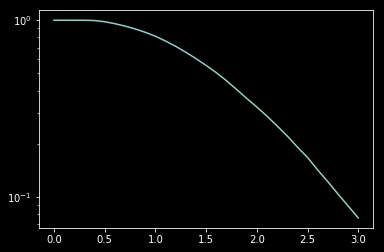

In [16]:
plt.plot(xnicer.calibration[0], xnicer.calibration[2]);
plt.yscale('log');

BIAS: -0.006321835342861222
STDV: 0.1429647483939252
ERR:  0.14291384488266773
Mean err: 0.17611362130944988
Real err: 0.18059753492436403


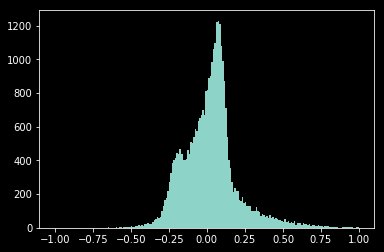

In [20]:
w = np.where(np.all(cat_s['mag_errs'] < cat_s.meta['max_err'], axis=(1,)))[0]
# w = np.arange(len(cat_s))
ext = xnicer.predict(cat_s[w], n_iters=3)

objweight = 1.0 / ext['variance_A']
print("BIAS:", np.sum(ext['mean_A'] * objweight) / np.sum(objweight))
print("STDV:", np.sqrt(np.sum(ext['mean_A']**2 * objweight**2) 
                       / np.sum(objweight)**2) * np.sqrt(len(objweight)))
print("ERR: ", np.sqrt(len(objweight) / np.sum(objweight)))
print("Mean err:", np.mean(np.sqrt(ext['variance_A'])))
print("Real err:", np.std(ext['mean_A']));
plt.hist(ext['mean_A'], bins=200, range=[-1, 1]);

In [32]:
xnicer.calibration

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 array([-0.01011246,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]),
 array([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]))

In [26]:
xnicer.calibration = None


BIAS: 0.00758188224952654
STDV: 0.14754660873734443
ERR:  0.11100399522893974
Mean err: 0.1195137439385887
Real err: 0.14225262362145538


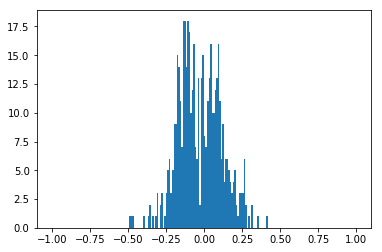

In [16]:
cat_s2 = cat_s1.extinguish(3.0)
w = np.where(np.all(cat_s2['mag_errs'] < cat_s2.meta['max_err'], axis=(1,)))[0]
# w = np.arange(len(cat_s2))
ext = xnicer.predict(cat_s2[w], n_iters=3)
ext['mean_A'] -= 3.0

objweight = 1.0 / ext['variance_A']
print("BIAS:", np.sum(ext['mean_A'] * objweight) / np.sum(objweight))
print("STDV:", np.sqrt(np.sum(ext['mean_A']**2 * objweight**2) 
                       / np.sum(objweight)**2) * np.sqrt(len(objweight)))
print("ERR: ", np.sqrt(len(objweight) / np.sum(objweight)))
print("Mean err:", np.mean(np.sqrt(ext['variance_A'])))
print("Real err:", np.std(ext['mean_A']));
plt.hist(ext['mean_A'], bins=200, range=[-1, 1]);

BIAS: -0.010617256034010649
STDV: 0.14114896033649837
ERR:  0.14626695429544087
Mean err: 0.17046577372779564
Real err: 0.18015037346963791


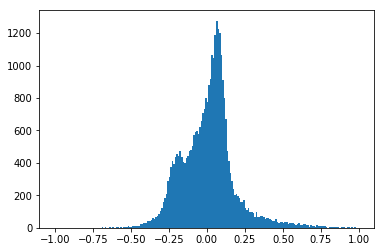

In [6]:
w = np.where(np.all(cat_s1['mag_errs'] < cat_s1['max_err'], axis=(1,)))[0]
#w = np.arange(len(cat_s1))
ext = xnicer.predict(cat_s1[w], n_iters=3)

objweight = 1.0 / ext['variance_A']
print("BIAS:", np.sum(ext.mean_A * objweight) / np.sum(objweight))
print("STDV:", np.sqrt(np.sum(ext.mean_A**2 * objweight**2) 
                       / np.sum(objweight)**2) * np.sqrt(len(objweight)))
print("ERR: ", np.sqrt(len(objweight) / np.sum(objweight)))
print("Mean err:", np.mean(np.sqrt(ext.variance_A)))
print("Real err:", np.std(ext.mean_A));
plt.hist(ext.mean_A, bins=200, range=[-1, 1]);

BIAS: -0.010617256034010649
STDV: 0.14114896033649837
ERR:  0.14626695429544087
Mean err: 0.17046577372779564
Real err: 0.18015037346963791


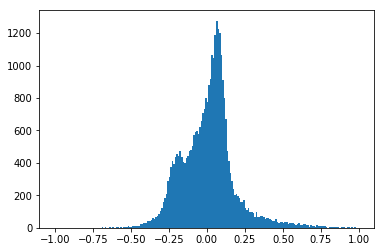

In [13]:
cat_s2 = cat_s1.extinguish(0.0)
w = np.where(np.all(cat_s2.mag_errs < cat_s2.max_err, axis=(1,)))[0]
#w = np.arange(len(cat_s1))
ext = xnicer.predict(cat_s2[w], n_iters=3)
ext.mean_A -= 0.0

objweight = 1.0 / ext.variance_A
print("BIAS:", np.sum(ext.mean_A * objweight) / np.sum(objweight))
print("STDV:", np.sqrt(np.sum(ext.mean_A**2 * objweight**2) 
                       / np.sum(objweight)**2) * np.sqrt(len(objweight)))
print("ERR: ", np.sqrt(len(objweight) / np.sum(objweight)))
print("Mean err:", np.mean(np.sqrt(ext.variance_A)))
print("Real err:", np.std(ext.mean_A));
plt.hist(ext.mean_A, bins=200, range=[-1, 1]);

BIAS: -0.002314588471151878
STDV: 0.16047121276774443
ERR:  0.13863438146066664
Mean err: 0.17473239461017206
Real err: 0.18616770683353842


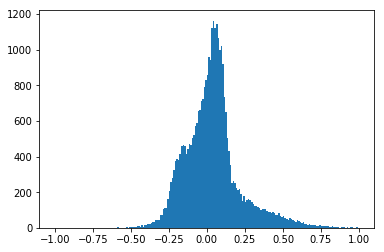

In [8]:
w = np.where(np.all(cat_s.mag_errs < cat_s.max_err, axis=(1,)))[0]
#w = np.arange(len(cat_s))
ext = xnicer.predict(cat_s[w], n_iters=3)

objweight = 1.0 / ext.variance_A
print("BIAS:", np.sum(ext.mean_A * objweight) / np.sum(objweight))
print("STDV:", np.sqrt(np.sum(ext.mean_A**2 * objweight**2) 
                       / np.sum(objweight)**2) * np.sqrt(len(objweight)))
print("ERR: ", np.sqrt(len(objweight) / np.sum(objweight)))
print("Mean err:", np.mean(np.sqrt(ext.variance_A)))
print("Real err:", np.std(ext.mean_A));
plt.hist(ext.mean_A, bins=200, range=[-1, 1]);

In [7]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [10]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.932   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.900   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.866   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.828   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.786   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.739   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.690   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.639   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.592   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.548   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.508   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.472   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.437   lengthscale: 0.273   noise: 0.259
Iter 14/50 - Loss: 0.404   lengthscale: 0.257   noise: 0.237
Iter 15/50 - Loss: 0.370   lengthscale: 0.245   noise: 0.216
Iter 16/50 - Loss: 0.337   lengthscale: 0.235   noise: 0.197
Iter 17/50 - Loss: 0.305   length

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

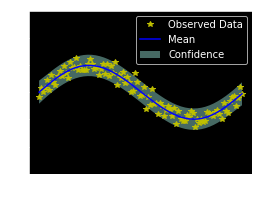

In [14]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'y*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])